In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


from sklearn.preprocessing import LabelEncoder

import statsmodels.api as sm

Reading the data again

In [2]:
df_occurrences = pd.read_csv('../TC_Data/RODSdb_MDOTW_VW_OCCURRENCE_PUBLIC.csv',low_memory=False)
df_train = pd.read_csv('../TC_Data/RODSdb_MDOTW_VW_TRAIN_PUBLIC.csv',low_memory=False)
df_rolling_stock = pd.read_csv('../TC_Data/RODSdb_MDOTW_VW_ROLLING_STOCK_PUBLIC.csv',low_memory=False)
df_injuries = pd.read_csv('../TC_Data/RODSdb_MDOTW_VW_INJURIES_PUBLIC.csv',low_memory=False)
df_components = pd.read_csv('../TC_Data/RODSdb_MDOTW_VW_COMPONENTS_PUBLIC.csv',low_memory=False)

###########
# reading the csv that has the discription of the columns in the csvs
# was getting this error ' 'utf-8' codec can't decode byte 0x93 in position 47142: invalid start byte'
df_disc = pd.read_csv('../TC_Data/RODSdb-dd.csv',encoding='unicode_escape')

### Grade crossing dataset and data dictionary
Source: https://open.canada.ca/data/en/dataset/d0f54727-6c0b-4e5a-aa04-ea1463cf9f4c

In [3]:
df_gc_dd = pd.read_excel('../TC_Data/grade_crossing_inventory_data_dictionary.xls')
df_gc = pd.read_excel('../TC_Data/grade_crossings_inventory_-_rail_safety_dataset_en.xlsx')

### Merging 

In [4]:
# creating the keys that df_occ and df_gc can be combined on
df_occurrences['TC Number'] = df_occurrences['TCNo']
df_occurrences['TC Number'] = df_occurrences['TC Number'].astype(str)
df_gc['TC Number'] = df_gc['TC Number'].astype(str)

# merging df_occ with df_train
df = pd.merge(df_occurrences,df_train,how='left',on=['OccID','OccID'])
# merging then with df_gc
df = pd.merge(df,df_gc,how='left',on=['TC Number','TC Number'])

# now have occurrences, trains, and at grade crossings merged into a single df
df.to_csv('../Data/occurrence_gradecrossing_train.csv')

In [5]:
def remove_duplicates_from_list(a_list):
    '''pass in a list
    return a list with duplicates removed'''
    return list(dict.fromkeys(a_list))

In [6]:
descriptive_list =[
    'Location','AccIncTypeID_DisplayEng','OccurrenceTypeID_DisplayEng',
    'SubdOwnerID_DisplayEng','TrackTypeID_DisplayEng','CrossingTypeID_DisplayEng',
    'ProvinceID_DisplayEng',
    'DriverActionID_DisplayEng','VehicleTypeID_DisplayEng',
    'TrainTypeID_DisplayEng','ApproxTrainSpeed_MPH','NumCars','TrainLength_Feet'
    'Train Max Speed (mph)','Road Max Speed (km/h)',
    'Lanes','Tracks','Latitude_x','Longitude_x','Latitude_y','Longitude_y','NumTrainsDaily','NumVehiclesDaily']

In [7]:

feature_list = [
    'OccDate','Location','OccurrenceTypeID','AccIncTypeID','SubdOwnerID',
    'Latitude_x','Longitude_x','Latitude_y','Longitude_y',
    'TrackTypeID','CrossingTypeID',
    'NumTrainsDaily','Trains Daily','NumVehiclesDaily','Vehicles Daily',
    'ProvinceID','DriverActionID','VehicleTypeID','Count',
    'TrainTypeID','ApproxTrainSpeed_MPH','NumCars','TrainLength_Feet'
    'Train Max Speed (mph)','Road Max Speed (km/h)',
    'Lanes','Tracks','Count',
    # descriptive columns
    'AccIncTypeID_DisplayEng','OccurrenceTypeID_DisplayEng',
    'SubdOwnerID_DisplayEng','TrackTypeID_DisplayEng','CrossingTypeID_DisplayEng',
    'ProvinceID_DisplayEng',
    'DriverActionID_DisplayEng','VehicleTypeID_DisplayEng',
    'TrainTypeID_DisplayEng'
]           

In [8]:
df_og = df.copy()

In [9]:
df = df_og.copy()

In [10]:
df['OccDate'] = pd.to_datetime(df['OccDate'])
df['Year'] = df['OccDate'].dt.year
df['Month'] = df['OccDate'].dt.month
df['Day'] = df['OccDate'].dt.day

In [11]:
df.to_csv('../Data/wrangled_data.csv')

In [12]:
df['Count']=1

In [13]:
#########################################

In [14]:
#### filtering to the last 20 years

In [15]:
year_set = set()
for i in range(2003,2023):
    year_set.add(i)

# last 20 years
df = df[df['Year'].isin(year_set)]

# only accidents at crossings
df = df[df['AccIncTypeID_DisplayEng']=='CROSSING']

In [16]:
# it seems both the occurrences csv and the grade crossing inv have the amount of trains passing with difference
# The values from the occurrences has fewer missing values so I'll be using those. 
print(df['NumTrainsDaily'].isnull().sum()) # from occurrences
print(df['Trains Daily'].isnull().sum()) # from gc
df.loc[:,['NumTrainsDaily','Trains Daily']].describe()


529
669


,NumTrainsDaily,Trains Daily
count,3535.000000,3395.000000
mean,13.941443,13.275060
std,13.631965,14.462841
min,0.000000,0.000000
25%,4.000000,4.000000
50%,10.000000,9.000000
75%,22.000000,18.000000
max,132.000000,162.000000


In [17]:
df = df.drop(labels='Trains Daily',axis=1)

In [18]:
df_descriptive = df.filter(descriptive_list)
df_descriptive

,Location,AccIncTypeID_DisplayEng,OccurrenceTypeID_DisplayEng,SubdOwnerID_DisplayEng,TrackTypeID_DisplayEng,CrossingTypeID_DisplayEng,ProvinceID_DisplayEng,DriverActionID_DisplayEng,VehicleTypeID_DisplayEng,TrainTypeID_DisplayEng,...,NumCars,Road Max Speed (km/h),Lanes,Tracks,Latitude_x,Longitude_x,Latitude_y,Longitude_y,NumTrainsDaily,NumVehiclesDaily
266,40 Avenue,CROSSING,ACCIDENT,CN - CANADIAN NATIONAL RAILWAY CO.,MAIN,PUBLIC AUTOMATED,SASKATCHEWAN,DID NOT STOP,LIGHT TRUCK,FREIGHT,...,46.0,50.0,2.0,1.0,531700.0,1100000.0,53.28260,-109.97900,3.0,3360.0
277,Rge Rd 3232 (Cemetary),CROSSING,ACCIDENT,CP - CANADIAN PACIFIC RAILWAY CO.,MAIN,PUBLIC PASSIVE,SASKATCHEWAN,STOPPED ON TRACK,AUTOMOBILE,FREIGHT,...,114.0,80.0,1.0,1.0,522700.0,1091000.0,52.46453,-109.21740,6.0,30.0
278,Hwy 12 (Gamebridge),CROSSING,ACCIDENT,CN - CANADIAN NATIONAL RAILWAY CO.,MAIN,PUBLIC AUTOMATED,ONTARIO,STOPPED ON TRACK,AUTOMOBILE,FREIGHT,...,27.0,80.0,2.0,1.0,443200.0,791000.0,44.53730,-79.17220,16.0,7000.0
279,Cherry Hill,CROSSING,ACCIDENT,CN - CANADIAN NATIONAL RAILWAY CO.,MAIN,PUBLIC AUTOMATED,ONTARIO,STOPPED ON TRACK,AUTOMOBILE,COMMUTER,...,10.0,80.0,2.0,1.0,430600.0,810800.0,43.20600,-81.13710,8.0,200.0
288,Dundonald Road (Highway 80),CROSSING,ACCIDENT,CP - CANADIAN PACIFIC RAILWAY CO.,MAIN,PUBLIC AUTOMATED,ONTARIO,SKIDDED ON TRACK,AUTOMOBILE,FREIGHT,...,147.0,80.0,2.0,1.0,424500.0,814300.0,42.76400,-81.73200,20.0,1500.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33140,Rue Fabre,CROSSING,ACCIDENT,CN - CANADIAN NATIONAL RAILWAY CO.,MAIN,PUBLIC AUTOMATED,QUÉBEC,DID NOT STOP,AUTOMOBILE,FREIGHT,...,33.0,50.0,2.0,1.0,451500.0,740800.0,45.26480,-74.11260,7.0,2700.0
33143,Range Road 22,CROSSING,ACCIDENT,CN - CANADIAN NATIONAL RAILWAY CO.,MAIN,PUBLIC PASSIVE,ALBERTA,DID NOT STOP,DG TANK TRUCK,FREIGHT,...,125.0,80.0,2.0,1.0,531700.0,1101000.0,53.29295,-110.20059,5.0,100.0
33147,NaN,CROSSING,ACCIDENT,CN - CANADIAN NATIONAL RAILWAY CO.,MAIN,PRIVATE,ONTARIO,ABANDONED VEHICLE,AUTOMOBILE,FREIGHT,...,91.0,NaN,NaN,NaN,441900.0,791200.0,NaN,NaN,16.0,4.0
33148,NaN,CROSSING,ACCIDENT,CN - CANADIAN NATIONAL RAILWAY CO.,MAIN,PRIVATE,ONTARIO,ABANDONED VEHICLE,AUTOMOBILE,FREIGHT,...,91.0,NaN,NaN,NaN,441900.0,791200.0,NaN,NaN,16.0,4.0


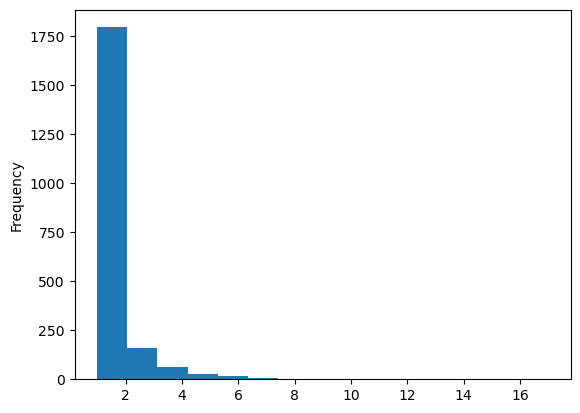

In [19]:
# plot of the frequency of the counts of accidents at locations
df_descriptive['Location'].value_counts().plot(kind='hist',bins=15)
plt.show()

Using the GC as the base df to included the gc that have no accidents.

In [20]:
df_occurrences = pd.read_csv('../TC_Data/RODSdb_MDOTW_VW_OCCURRENCE_PUBLIC.csv',low_memory=False)
df_train = pd.read_csv('../TC_Data/RODSdb_MDOTW_VW_TRAIN_PUBLIC.csv',low_memory=False)
df_gc = pd.read_excel('../TC_Data/grade_crossings_inventory_-_rail_safety_dataset_en.xlsx')

In [21]:
df_occurrences['TC Number'] = df_occurrences['TCNo']
df_occurrences['TC Number'] = df_occurrences['TC Number'].astype(str)
df_occurrences['Count'] = 1
df_gc['TC Number'] = df_gc['TC Number'].astype(str)


year_set = set()
for i in range(2003,2023):
    year_set.add(i)

df_occurrences['OccDate'] = pd.to_datetime(df_occurrences['OccDate'])
df_occurrences['Year'] = df_occurrences['OccDate'].dt.year
df_occurrences['Month'] = df_occurrences['OccDate'].dt.month
df_occurrences['Day'] = df_occurrences['OccDate'].dt.day


# last 20 years of occurrences
df_occurrences = df_occurrences[df_occurrences['Year'].isin(year_set)]

# as i'm using the gc as the base df i'm going to use the Trains Daily over the NumTrainsDaily that was used earlier
# df = df.drop(labels='NumTrainsDaily',axis=1)
# df['Year'].value_counts()
df_occurrences['Count'].info()



<class 'pandas.core.series.Series'>
Int64Index: 29711 entries, 162 to 30698
Series name: Count
Non-Null Count  Dtype
--------------  -----
29711 non-null  int64
dtypes: int64(1)
memory usage: 464.2 KB


In [22]:
df1 = pd.merge(df_occurrences,df_train,how='left',on=['OccID','OccID'])

df = pd.merge(df_gc,df1,how='left',on=['TC Number','TC Number'])

In [23]:
df['Count']=df['Count'].fillna(0)
df['Count'].info()
df['Count']=df['Count'].astype(str)
df['Count'].value_counts()
df['Count']=df['Count'].astype('float32')

<class 'pandas.core.series.Series'>
Int64Index: 26302 entries, 0 to 26301
Series name: Count
Non-Null Count  Dtype  
--------------  -----  
26302 non-null  float64
dtypes: float64(1)
memory usage: 411.0 KB


In [24]:
# df.to_csv('../Data/gradecrossing_occurrence_train.csv')

In [25]:
df_og = df.copy()

In [26]:
###########################################

In [27]:
df = df_og.copy()

In [28]:
df['AccIncTypeID_DisplayEng'].value_counts()
df['Count'].value_counts()

0.0    22907
1.0     3395
Name: Count, dtype: int64

In [29]:
df[['Location','Count']]

,Location,Count
0,Burloak Dr,1.0
1,Burloak Dr,1.0
2,D'Arcy St,1.0
3,D'Arcy St,1.0
4,D'Arcy St,1.0
...,...,...
26297,"116 Avenue, East of 178 Street",0.0
26298,9 Avenue N W 32 Street R,0.0
26299,2 Avenue N W 39 Street B,0.0
26300,Access Road Private,0.0


In [30]:
len(df['Location'].unique())
len(df['Railway'].unique())
len(df['Protection'].unique())

4

In [31]:
df['Protection'].value_counts()

Passive          18412
Active - FLB      4385
Active - FLBG     3494
Active              11
Name: Protection, dtype: int64

In [32]:
group_by_dictionary = {
    'Trains Daily':'mean',
    # 'NumVehiclesDaily':'mean',
    'Count':'sum',
    'Train Max Speed (mph)':'mean',
    'Road Max Speed (km/h)':'mean',
    'Vehicles Daily':'mean'
    # 'ApproxTrainSpeed_MPH':'mean',
    # 'NumCars':'mean',
    # 'TrainLength_Feet':'mean'
    }

grp = df.groupby([
    'Location',
    'Province',
    'Railway',
    'Protection'
    # 'VehicleTypeID_DisplayEng',
    # 'TrainTypeID_DisplayEng',
    # 'SubdOwnerID_DisplayEng',
    ],as_index=False).agg(group_by_dictionary)

grp = grp.dropna()


In [33]:
# 

grp.to_csv('../Data/Group_by.csv')

In [34]:
numeric_features = [
    'Count',
    'Trains Daily',
    'Vehicles Daily',
    'Train Max Speed (mph)',
    'Road Max Speed (km/h)',
    ]


categorical_features = [
    'Province', 
    'Protection',
    'Railway'
    ]




In [35]:
for i in numeric_features:
    print(grp[i].describe())
    print('***********')

count    15374.000000
mean         0.212111
std          0.670572
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         17.000000
Name: Count, dtype: float64
***********
count    15374.000000
mean         7.472401
std         10.845568
min          0.000000
25%          2.000000
50%          4.000000
75%         10.000000
max        289.000000
Name: Trains Daily, dtype: float64
***********
count    15374.000000
mean      1321.295484
std       3888.768482
min          0.000000
25%         15.000000
50%         50.000000
75%        661.500000
max      65104.000000
Name: Vehicles Daily, dtype: float64
***********
count    15374.000000
mean        32.721474
std         15.801403
min          0.000000
25%         25.000000
50%         30.000000
75%         40.000000
max         95.000000
Name: Train Max Speed (mph), dtype: float64
***********
count    15374.000000
mean        60.245040
std         22.256062
min          0.000000
25%         50.0

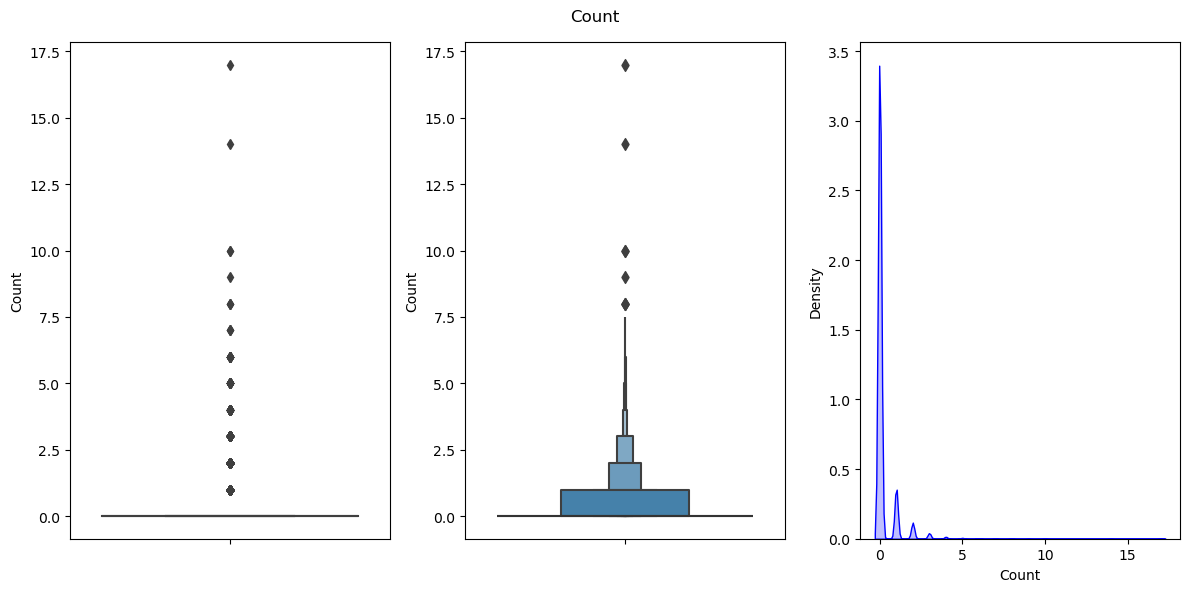

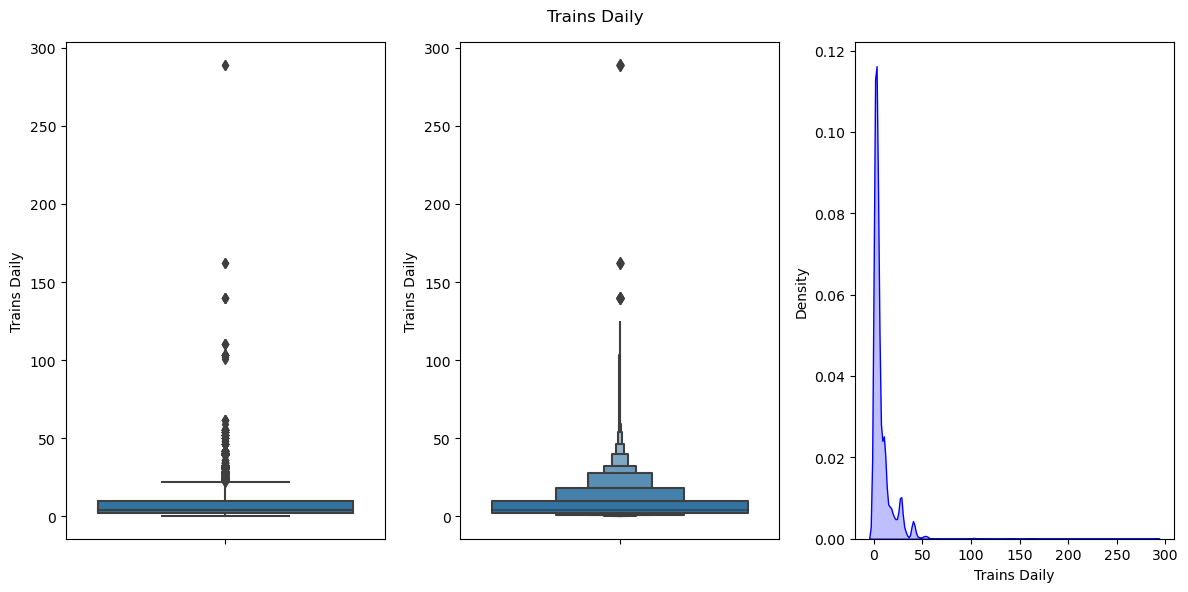

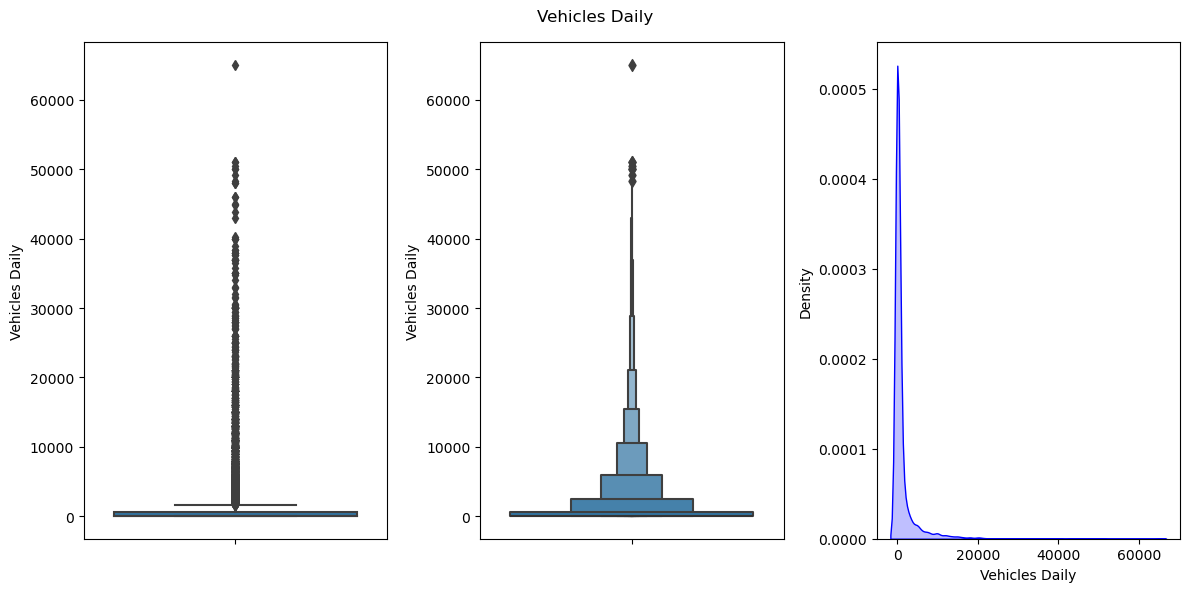

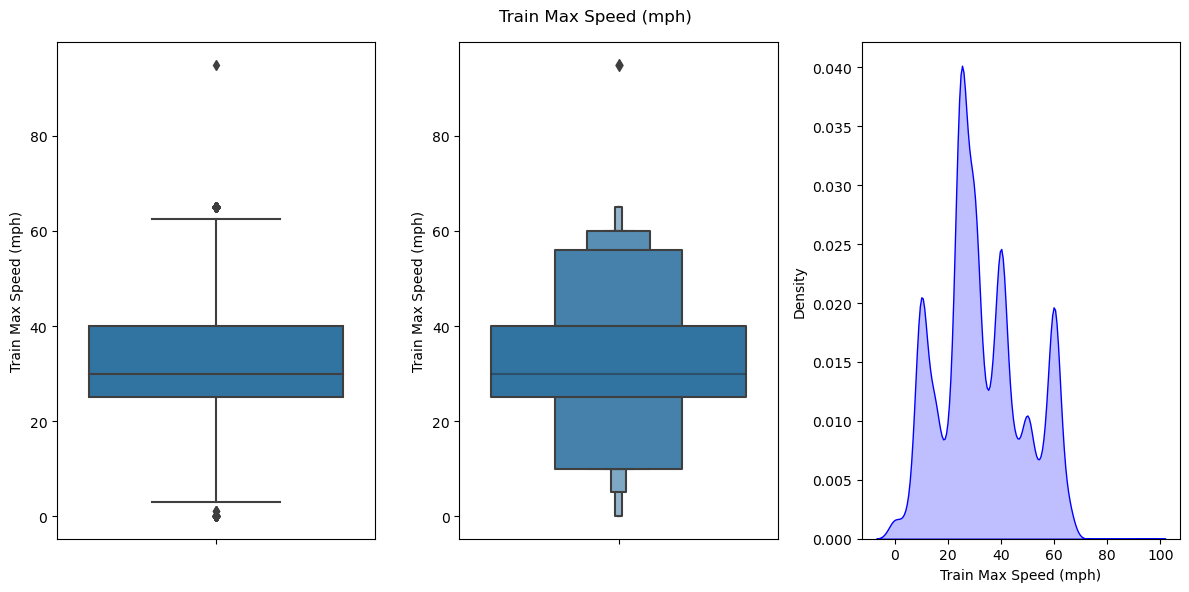

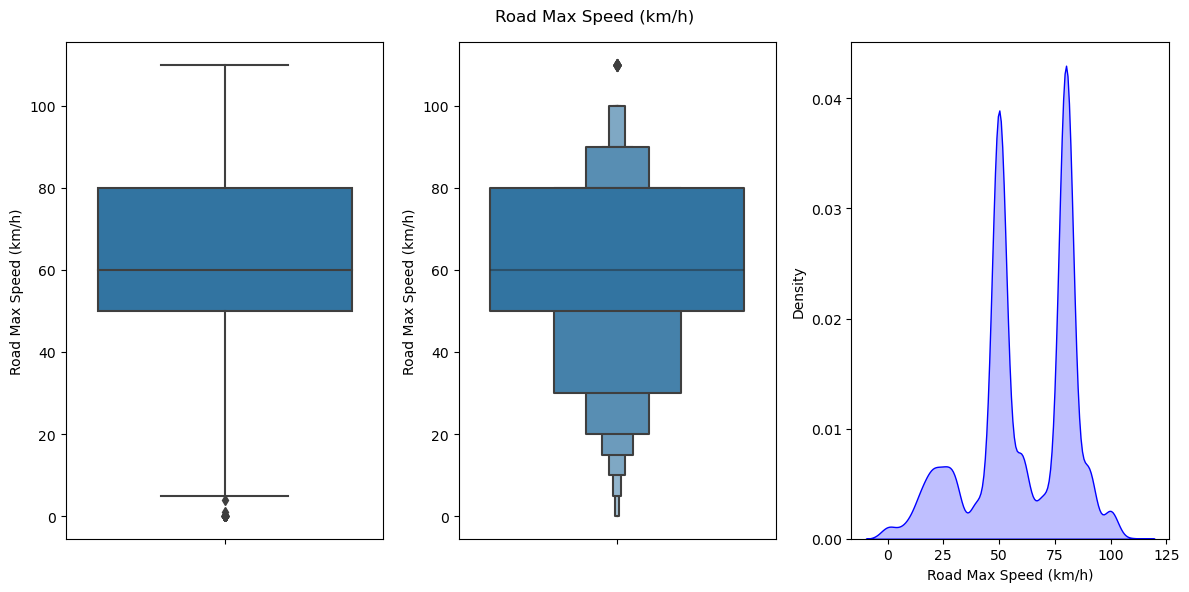

In [36]:
for i in numeric_features:
    fig, ax = plt.subplots(ncols=3, figsize=(12,6))
    sns.boxplot(y=i, data=grp, ax=ax[0])
    sns.boxenplot(y=i, data=grp, ax=ax[1])
    sns.kdeplot(x=i, data=grp, color='b', fill=True, ax=ax[2])
    fig.suptitle(i)
    fig.tight_layout()
    plt.show()



In [39]:
grp['Protection_en'] = LabelEncoder().fit_transform(np.asarray(grp['Protection']))
grp['Province_en'] = LabelEncoder().fit_transform(np.asarray(grp['Province']))
grp['Railway_en'] = LabelEncoder().fit_transform(np.asarray(grp['Railway']))

all_features=[
    'Count',
    'Trains Daily',
    'Vehicles Daily',
    'Train Max Speed (mph)',
    'Road Max Speed (km/h)',
    'Province_en', 
    'Protection_en',
    'Railway_en'
]

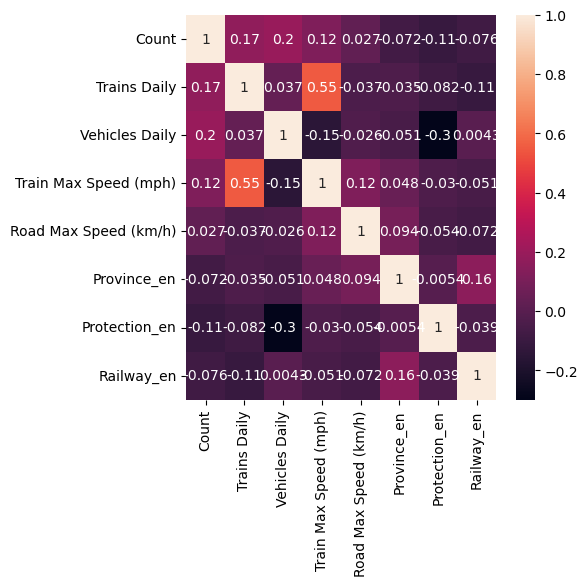

In [40]:
f, ax = plt.subplots(figsize=(5,5))
ax = sns.heatmap(grp[all_features].corr(), annot=True)

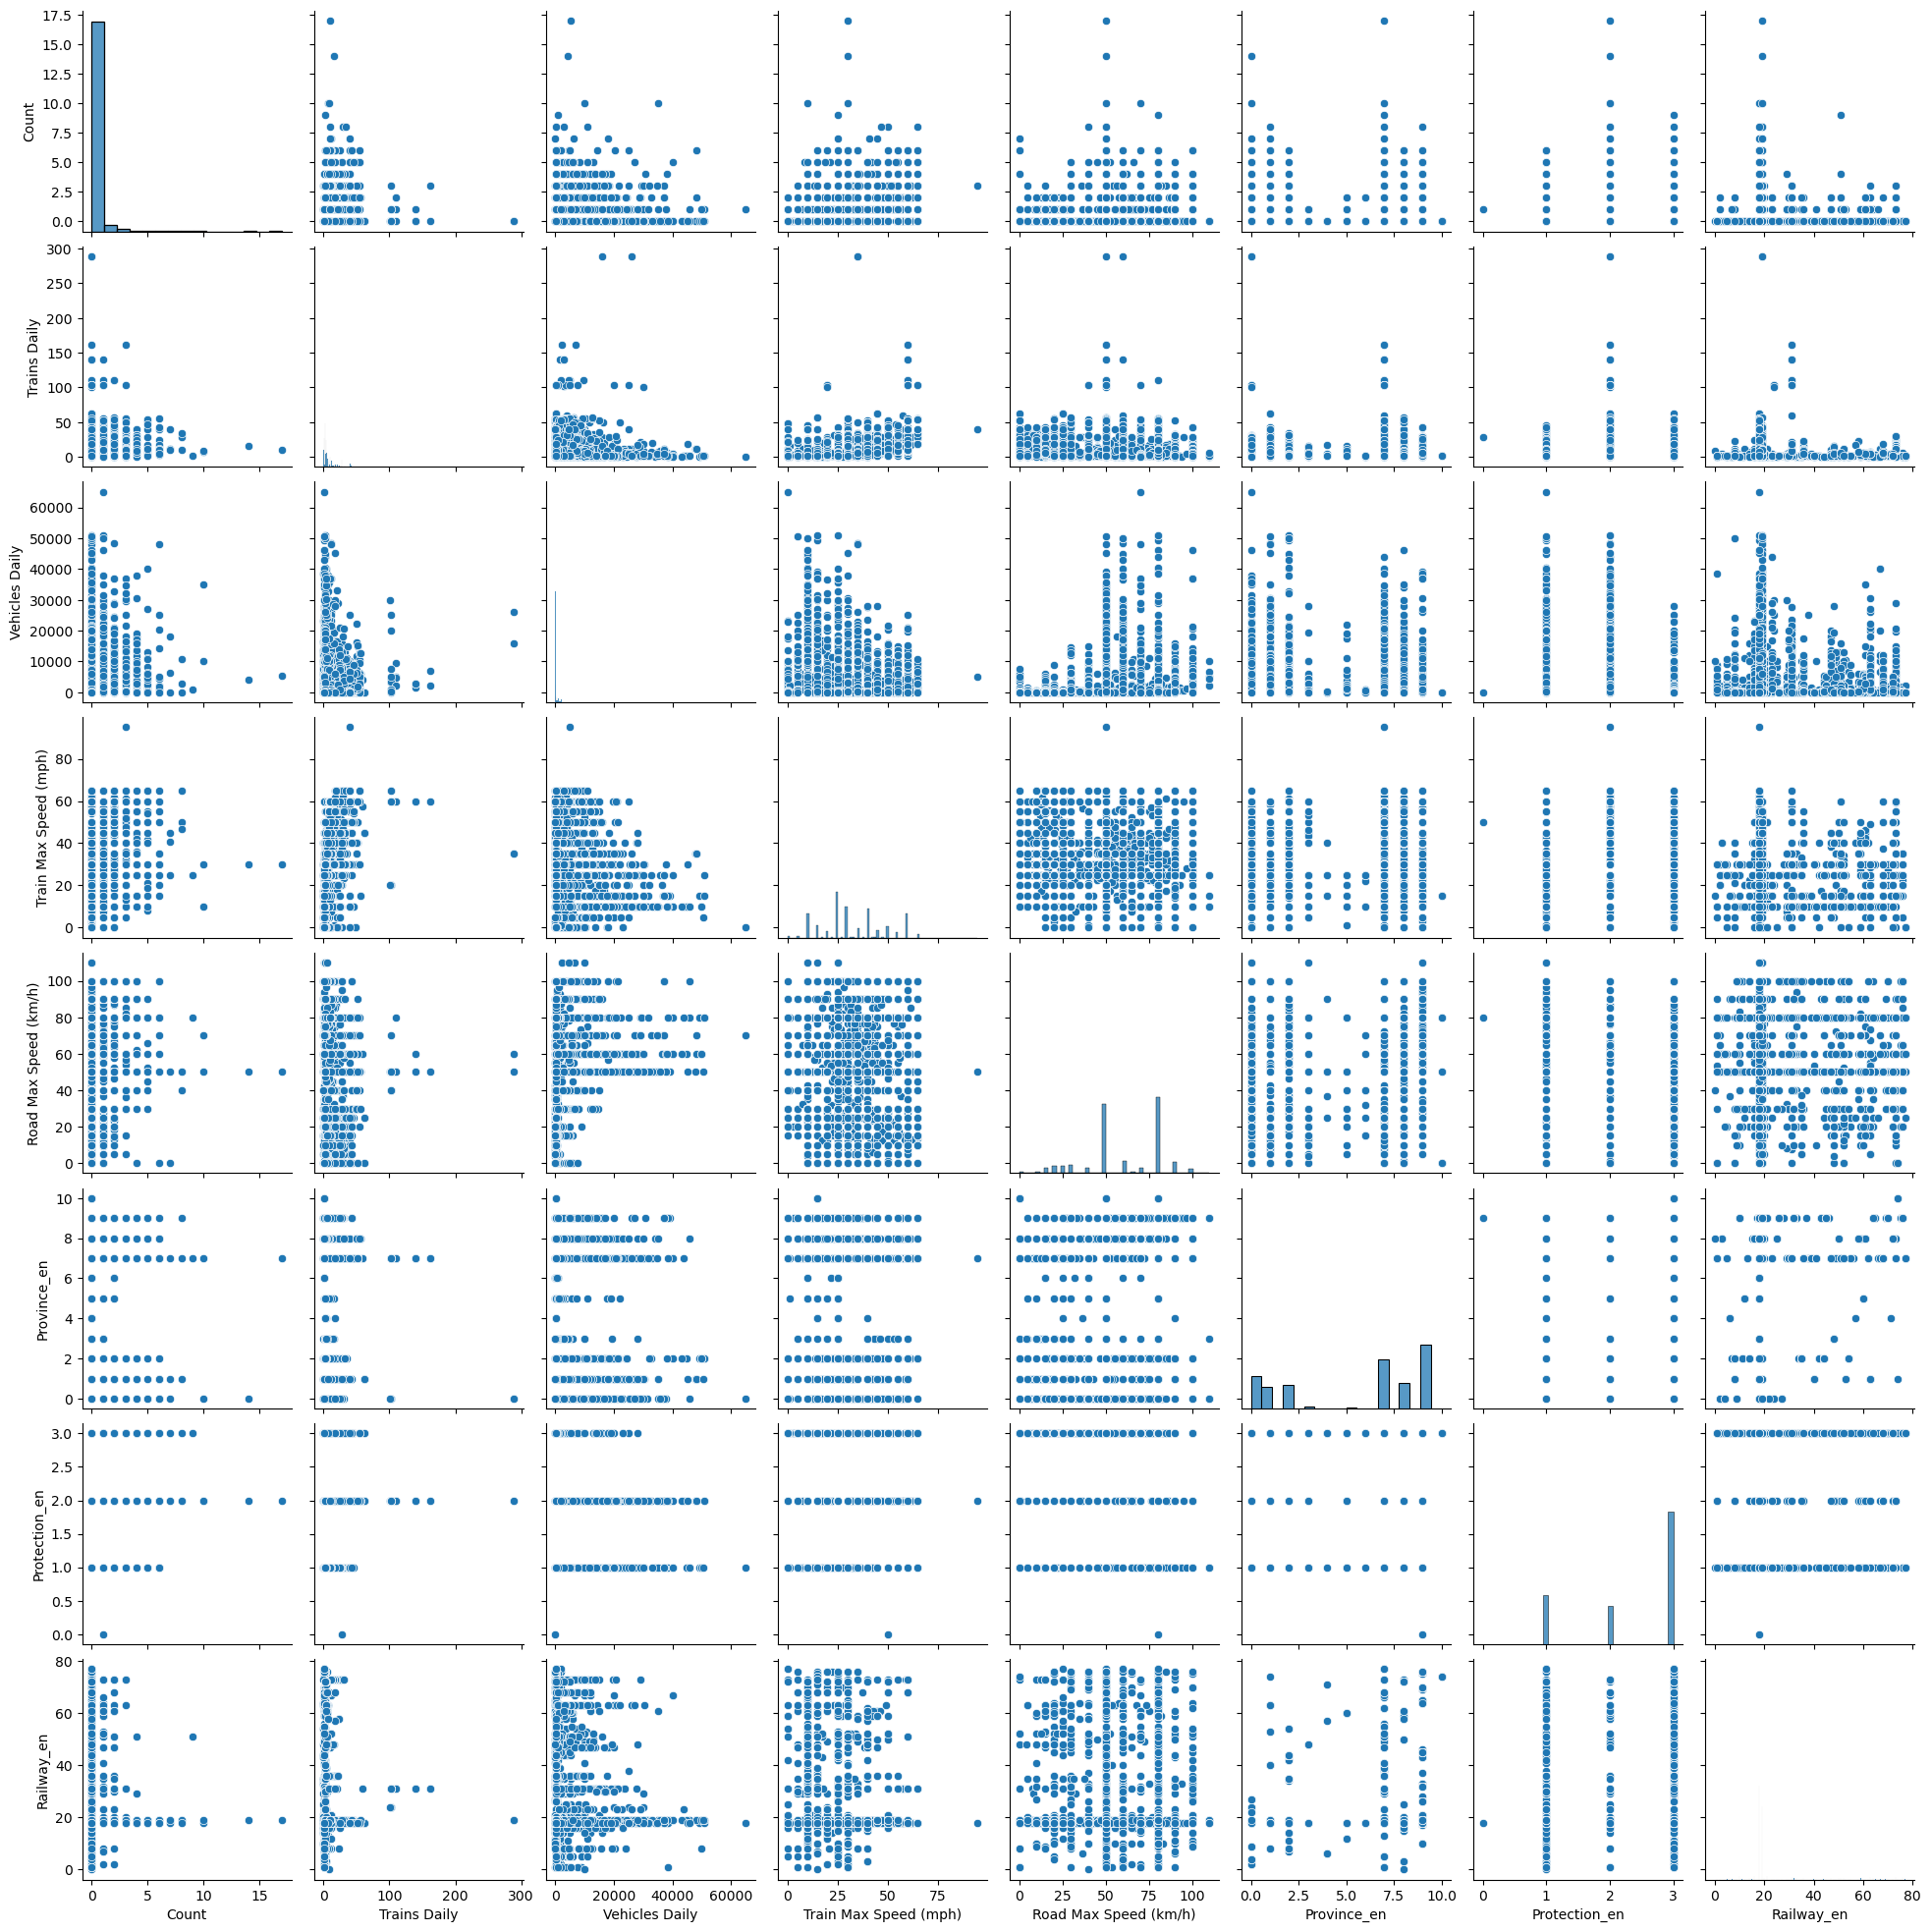

In [41]:
sns.pairplot(grp, vars=(all_features))

In [42]:
#############################################